# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

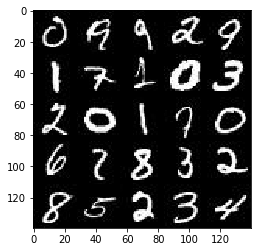

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

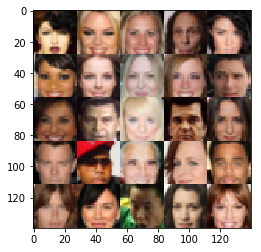

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    images     = tf.placeholder(tf.float32, [None] + [image_width, image_height, image_channels], name='images')
    embeddings = tf.placeholder(tf.float32, [None] + [z_dim], name='embeddings')
    learn_rate = tf.placeholder(tf.float32, name='learning_rate')

    return images, embeddings, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
import tensorflow.contrib.slim as slim

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xDIM
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x1 = tf.layers.conv2d(x1, 256, 3, strides=1, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xoutput_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    images, embeddings, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(images, embeddings, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={images: 2*batch_images, embeddings: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={embeddings: batch_z, images: 2*batch_images, learn_rate: learning_rate})

                # Run g optim twice
                batch_z_2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(g_train_opt, feed_dict={embeddings: batch_z_2, images: 2*batch_images, learn_rate: learning_rate})

                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({embeddings: batch_z, images: 2*batch_images})
                    train_loss_g = g_loss.eval({embeddings: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, embeddings, data_shape[3], data_image_mode)
                    
                steps += 1
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.5735... Generator Loss: 0.0023


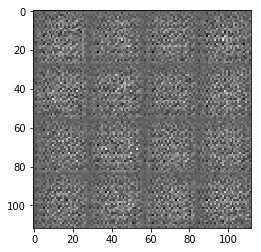

Epoch 1/2... Discriminator Loss: 4.6452... Generator Loss: 0.0946
Epoch 1/2... Discriminator Loss: 2.4678... Generator Loss: 0.4708
Epoch 1/2... Discriminator Loss: 2.0522... Generator Loss: 0.4031
Epoch 1/2... Discriminator Loss: 2.1969... Generator Loss: 0.3773
Epoch 1/2... Discriminator Loss: 1.9134... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 1.7911... Generator Loss: 0.4392
Epoch 1/2... Discriminator Loss: 1.8375... Generator Loss: 0.4884
Epoch 1/2... Discriminator Loss: 1.6537... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.6260... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.4824


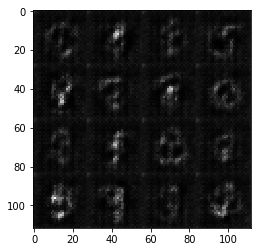

Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.5440
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 1.6742... Generator Loss: 1.0817
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.6719
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.6117
Epoch 1/2... Discriminator Loss: 1.4694... Generator Loss: 0.4354
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.5661... Generator Loss: 0.3636
Epoch 1/2... Discriminator Loss: 1.5271... Generator Loss: 0.3670


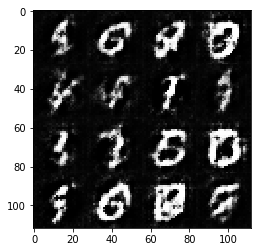

Epoch 1/2... Discriminator Loss: 1.2920... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 1.1453
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.5651
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.5333
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 1.3583... Generator Loss: 0.4582
Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 0.5379
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 1.6200... Generator Loss: 0.3147
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.7996


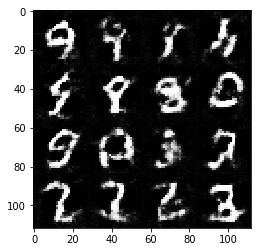

Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.4482
Epoch 1/2... Discriminator Loss: 1.4159... Generator Loss: 0.5188
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.7086
Epoch 1/2... Discriminator Loss: 1.6742... Generator Loss: 0.3383
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.5783
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.5213... Generator Loss: 0.3907
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.7762


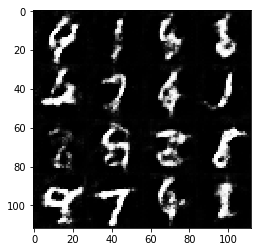

Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.9540
Epoch 1/2... Discriminator Loss: 1.4581... Generator Loss: 0.9779
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.6109
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 0.6434
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.6595
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.7223
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.4740
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.6412


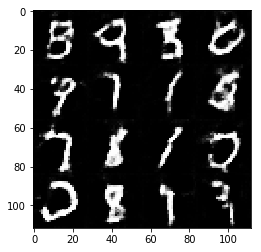

Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.5516
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.5282
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 1.1272
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.8860
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.5952
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.7939
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.6761
Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 0.5516


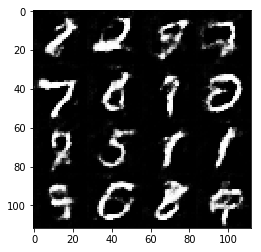

Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 0.6585
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.8612
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.8681
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 0.7198
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 1.3780... Generator Loss: 0.6032
Epoch 2/2... Discriminator Loss: 1.5247... Generator Loss: 0.3657
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.7087


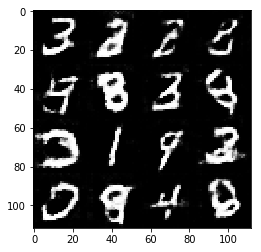

Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 0.4053
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 1.4980... Generator Loss: 1.4238
Epoch 2/2... Discriminator Loss: 1.4142... Generator Loss: 0.5738
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 1.0276
Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.4465
Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 1.4103... Generator Loss: 0.5212
Epoch 2/2... Discriminator Loss: 1.3120... Generator Loss: 0.6819
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.5300


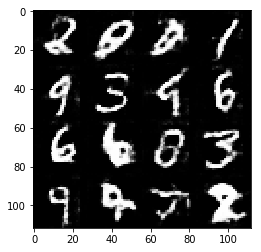

Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 0.5230
Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.6462
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.4311
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.6663
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.4667
Epoch 2/2... Discriminator Loss: 1.3024... Generator Loss: 0.6041
Epoch 2/2... Discriminator Loss: 1.4445... Generator Loss: 1.1981


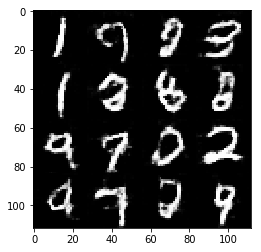

Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.6798
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.8137
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.6302


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 10.4029... Generator Loss: 0.0001


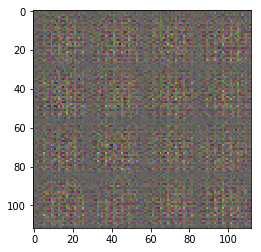

Epoch 1/1... Discriminator Loss: 4.5591... Generator Loss: 0.0607
Epoch 1/1... Discriminator Loss: 1.7114... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 2.3789... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 2.1755... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 2.1250... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 2.5385... Generator Loss: 0.2857
Epoch 1/1... Discriminator Loss: 2.5419... Generator Loss: 0.3697
Epoch 1/1... Discriminator Loss: 1.9174... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.7513... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 2.3865... Generator Loss: 0.4635


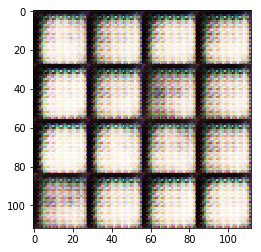

Epoch 1/1... Discriminator Loss: 1.8879... Generator Loss: 0.4156
Epoch 1/1... Discriminator Loss: 2.4592... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.8823... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.8413... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.9766... Generator Loss: 0.4172
Epoch 1/1... Discriminator Loss: 1.9791... Generator Loss: 0.5323
Epoch 1/1... Discriminator Loss: 1.7275... Generator Loss: 0.5864


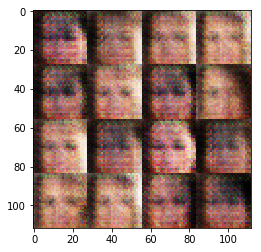

Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.7030... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.6551... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.7452... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.6740... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.7318... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.6757... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.7819... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.6990... Generator Loss: 0.5861


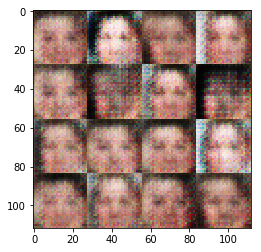

Epoch 1/1... Discriminator Loss: 1.8321... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.6275... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.6551... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.5524


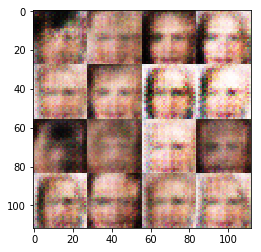

Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.7108... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.7678... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6414


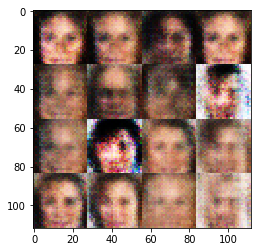

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.6318... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.7456... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.6348... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.6271


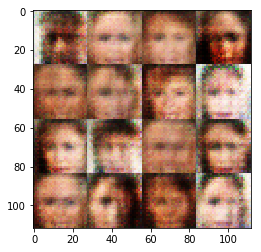

Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.6725... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.5770


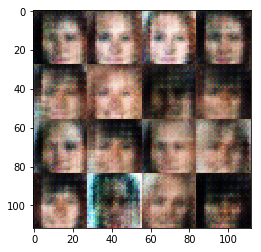

Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.6256


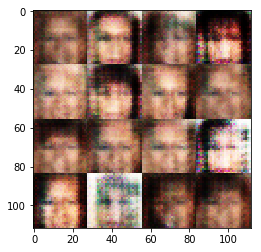

Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6464


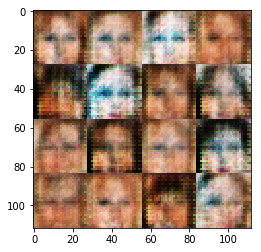

Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.6144


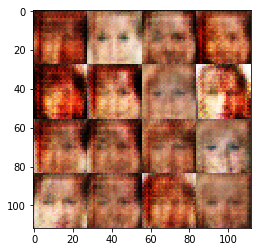

Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.7166


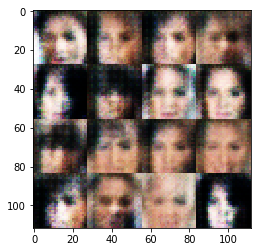

Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.5304... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7215


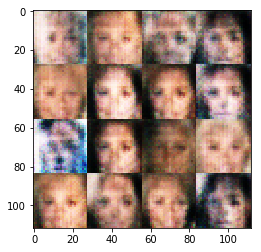

Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6797


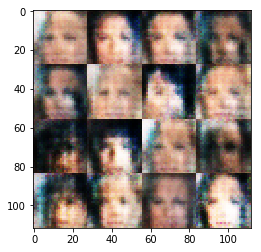

Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.5917


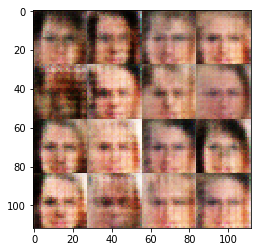

Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6293


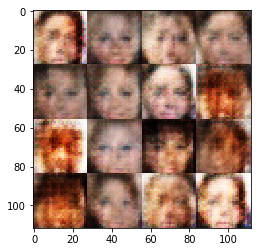

Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6674


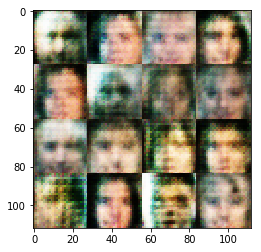

Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6987


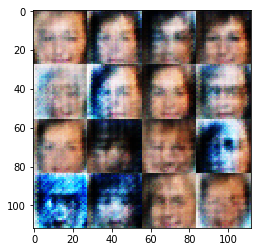

Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.5884... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6529


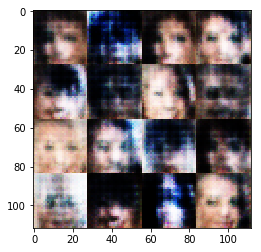

Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7093


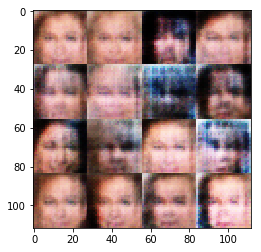

Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6243


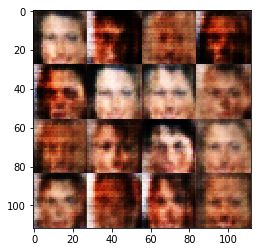

Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6578


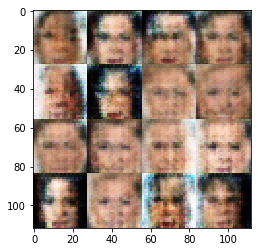

Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.6307


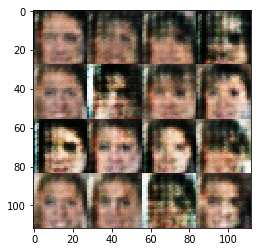

Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6826


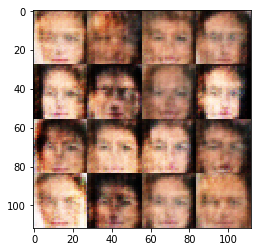

Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6427


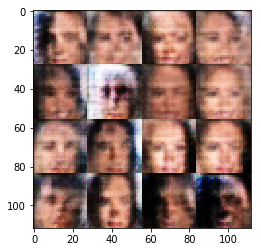

Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.6356


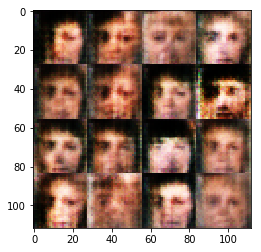

Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.6658


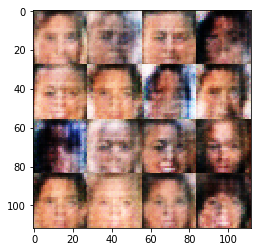

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6000


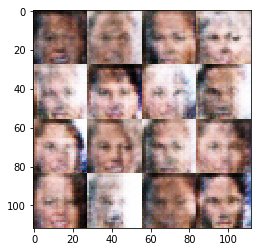

Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6590


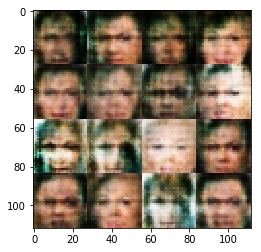

Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6276


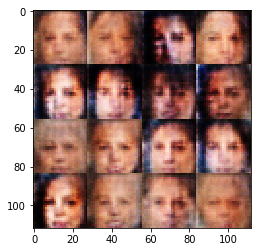

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6519


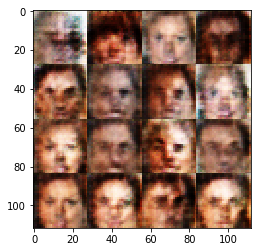

Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.6630


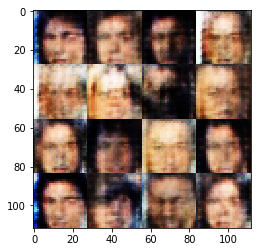

Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7114


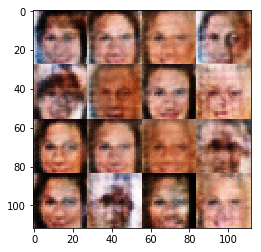

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6465


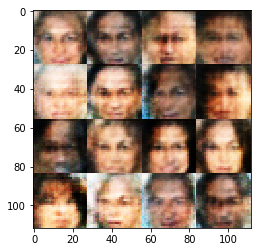

Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6711


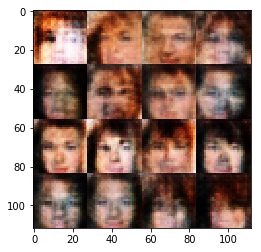

Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6458


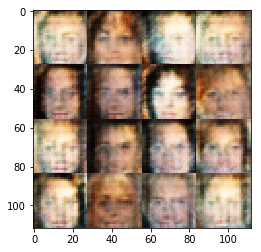

Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6446


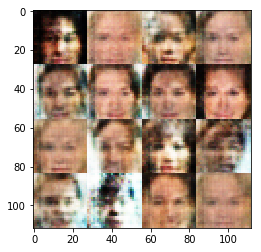

Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6343


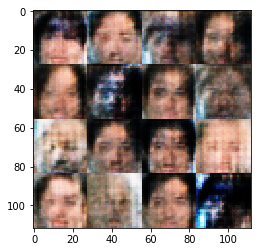

Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7364


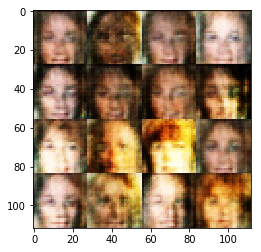

Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6795


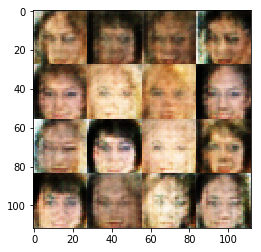

Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6693


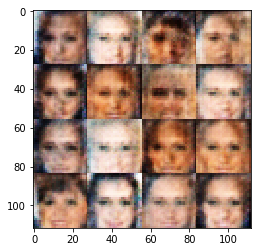

Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.6821


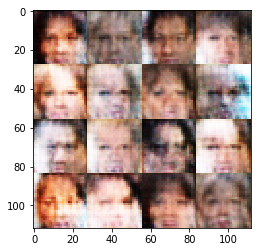

Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6846


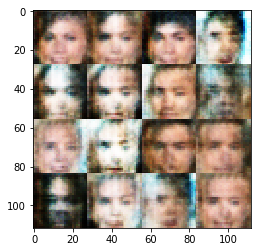

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6523


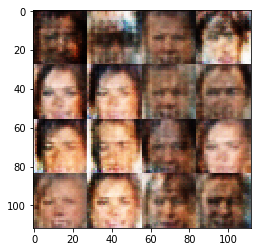

Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.6161


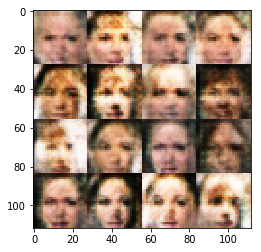

Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6514


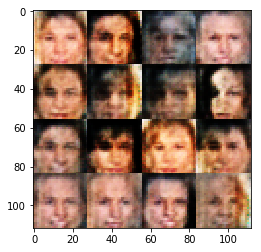

Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6851


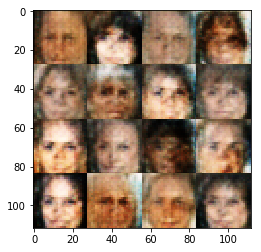

Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6550


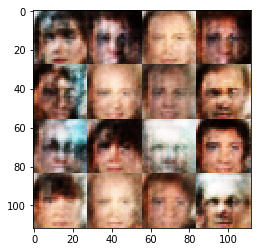

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6949


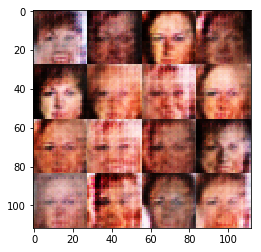

Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6486


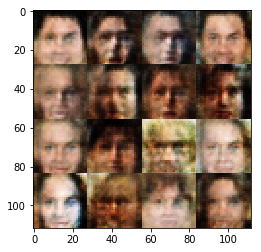

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7258


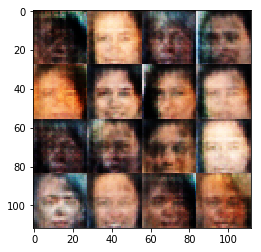

Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6457


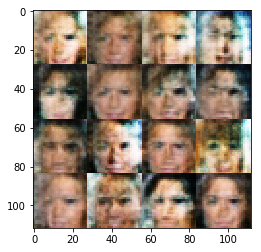

Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7025


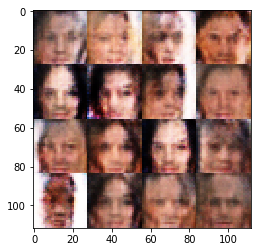

Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6711


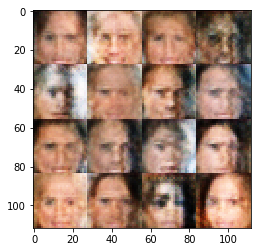

Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6629


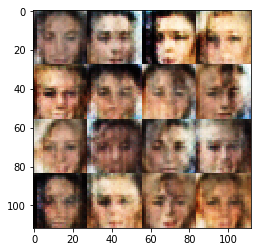

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6894


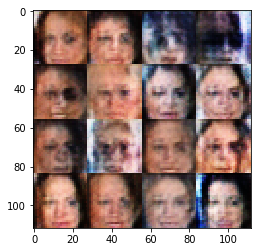

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6624


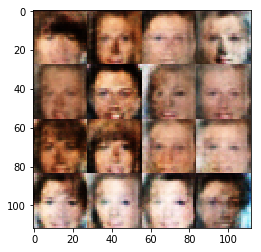

Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7007


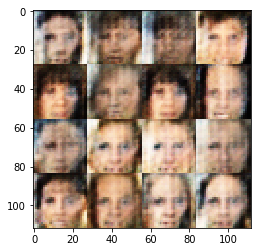

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6403


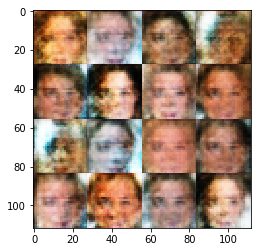

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6919


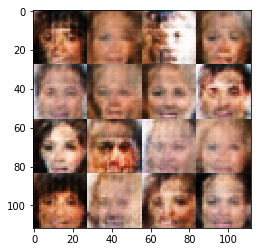

Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6713


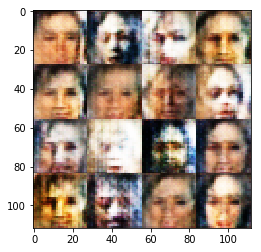

Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.6810


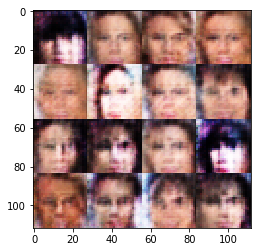

Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6994


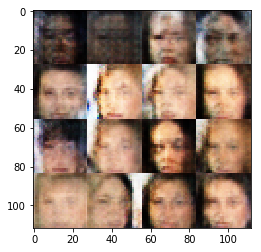

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.6787


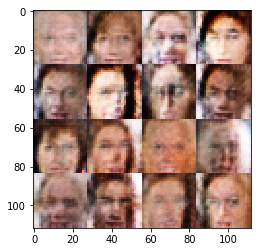

Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6473


In [12]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.